In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import matplotlib.colors as colors
import multiprocessing
import warnings

from nanonets.utils import BLUE_COLOR, RED_COLOR, get_net_currents, create_weighted_undirected_graph, display_net_flow_graph, extract_harmonic_features
from nanonets import Simulation
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull, KDTree
from scipy.spatial.distance import pdist
from scipy.stats import gaussian_kde
from tqdm import tqdm
from scipy.optimize import curve_fit

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="seaborn"
)

plt.style.use(["science","bright","grid"])
PATH    = "/home/j/j_mens07/bagheera/data/2_funding_period/dynamic/AC/freq_manipulation/f0_1/"
# PATH    = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/AC/freq_manipulation/f0_1/"
# PATH    = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/freq_manipulation/f0_1/"

PATH_R  = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/AC/res_disorder_freq_manipulation/"
# PATH_R  = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/AC/res_disorder_freq_manipulation/"

In [2]:
def MC_effective_volume(points, M_samples, fixed_radius, global_bounds):
    """
    Calculates the 'Effective Volume' of a high-dimensional point cloud using 
    Monte Carlo integration with a fixed probe radius.

    This function estimates the volume of the union of hyperspheres centered at each 
    data point. It is useful for quantifying the "reachable state space" or 
    "expressivity" of a reservoir computer in harmonic space.

    Parameters:
    -----------
    points : np.ndarray
        Array of shape (N_points, D_dimensions) containing the coordinates of the 
        reachable states (e.g., normalized harmonic phasors).
    M_samples : int
        Number of Monte Carlo samples to generate. Higher values reduce variance 
        but increase computation time. Suggest > 100,000 for D > 3.
    fixed_radius : float
        The radius of the hypersphere surrounding each point. This defines the 
        "resolution" of the volume.
        - Small radius: Measures point density (Volume ~ N * V_sphere).
        - Large radius: Approaches the Convex Hull volume (ignoring holes).
    global_bounds : tuple of (np.ndarray, np.ndarray)
        A tuple (min_bounds, max_bounds) defining the hyper-rectangle to sample within.
        Ensure these bounds fully enclose the 'points' + 'fixed_radius' to avoid clipping.

    Returns:
    --------
    float
        The estimated effective volume occupied by the point cloud.
    """
    
    # 1. Setup Bounding Box Dimensions
    min_bounds, max_bounds = global_bounds
    
    # Calculate the side lengths of the sampling box
    # (Vector of length D, allowing for non-cubic bounds)
    side_lengths = max_bounds - min_bounds
    
    # Calculate total volume of the sampling box (V_0)
    # This serves as the reference volume for the Monte Carlo integration
    v0_volume = np.prod(side_lengths)

    # 2. Generate Random Samples (Monte Carlo)
    # Create random points uniformly distributed within the [0, 1] hypercube
    raw_samples = np.random.rand(M_samples, points.shape[1])
    
    # Scale and shift samples to fit inside the 'global_bounds' box
    samples = raw_samples * side_lengths + min_bounds

    # 3. Neighbor Search (The "Hit" Test)
    # Build a KDTree for efficient nearest-neighbor lookup
    tree = KDTree(points)
    
    # Query the tree: Find the distance to the single nearest neighbor for each sample
    # k=1 returns only the nearest neighbor distance
    d_to_nn, _ = tree.query(samples, k=1)
    
    # 4. Count Hits
    # A sample is a "hit" if it falls within 'fixed_radius' of ANY point in the set
    hits = np.sum(d_to_nn <= fixed_radius)

    # 5. Calculate Effective Volume
    # V_eff = (Fraction of Hits) * (Total Box Volume)
    p_hit_rate = hits / M_samples
    v_mc_eff = p_hit_rate * v0_volume

    return v_mc_eff

def get_frequency_spectrum(signal, dt):
    """
    Computes the calibrated one-sided amplitude spectrum.
    
    Parameters:
    - signal: 1D numpy array (time domain)
    - dt: Time step in seconds
    
    Returns:
    - freqs: Array of frequencies [Hz]
    - amplitudes: Array of physical amplitudes [A] (or whatever unit signal is in)
    """
    N_samples = len(signal)
    
    # 1. Apply Window (Consistent with your previous analysis)
    window = np.blackman(N_samples)
    y_val = signal - np.mean(signal)
    y_windowed = y_val * window
    
    # Window Coherent Gain Correction
    w_gain = np.sum(window) / N_samples
    
    # 2. Compute FFT
    fft_vals = np.fft.rfft(y_windowed)
    freqs = np.fft.rfftfreq(N_samples, dt)
    
    # 3. Normalize Magnitude
    # Scale for one-sided (*2), normalize by N, correct for window loss
    amplitudes = (np.abs(fft_vals) * 2 / N_samples) / w_gain
    
    return freqs, amplitudes

def compute_spectral_centroid(amplitudes, harmonic_orders, exclude_fundamental=True):
    """
    Calculates the Spectral Centroid (Center of Mass of the Harmonic Spectrum).
    
    Formula: C = Sum(n * A_n^2) / Sum(A_n^2)
    (Weighted by Power, consistent with energy distribution)
    
    Parameters:
    - amplitudes: Array of magnitudes [A_1, A_3, A_5...]
    - harmonic_orders: Array of harmonic indices [1, 3, 5...]
    - exclude_fundamental: If True, calculates the centroid of the DISTORTION only (n > 1).
                           If False, includes the fundamental frequency.
    
    Returns:
    - centroid: The weighted average harmonic order (e.g., 3.5 means energy is between n=3 and n=5).
    """
    # Ensure inputs are numpy arrays
    amps = np.asarray(amplitudes)
    ords = np.asarray(harmonic_orders)
    
    # 1. Filter: Decide whether to include n=1
    if exclude_fundamental:
        # Only keep harmonics where n > 1
        mask = ords > 1
        valid_amps = amps[mask]
        valid_ords = ords[mask]
    else:
        valid_amps = amps
        valid_ords = ords
        
    # 2. Calculate Power (Square of Amplitude)
    power = valid_amps**2
    total_power = np.sum(power)
    
    # 3. Safety Check for Zero Distortion
    if total_power < 1e-20:
        return np.nan # No harmonic energy exists
        
    # 4. Calculate Centroid
    # Sum(n * Power) / Sum(Power)
    centroid = np.sum(valid_ords * power) / total_power
    
    return centroid

def compute_thd(amplitudes):
    """
    Calculates Total Harmonic Distortion (THD).
    Input: Array of amplitudes [A_fund, A_harm1, A_harm2, ...]
    """
    if len(amplitudes) < 2 or amplitudes[0] == 0:
        return 0.0
        
    power_fund = amplitudes[0]**2
    power_harm = np.sum(amplitudes[1:]**2)
    
    return np.sqrt(power_harm) / np.sqrt(power_fund)

def data_abundance(y):
    y   = np.asarray(y)
    x   = np.sort(y)
    p_x = 1. * np.arange(len(x)) / float(len(x) - 1)
    ab  = 100 - 100*p_x
    return x, ab

## Paramter and Input Time Series

In [ ]:
N_PARTICLES     = [3,5,7,9,11,13,15]
N_PERIODS       = 100
N_SAMPLES       = 608
SAMPLE_P_PERIOD = 40
F0              = 10.0
F0_HZ           = F0 * 1e6
AMPLITUDE       = 0.02
U_BOUNDS        = 0.05
N_EQ_PERIODS    = 80
DT              = 1 / (SAMPLE_P_PERIOD * F0_HZ)
T_SIM           = N_PERIODS / F0_HZ
N_STEPS         = int(np.ceil(T_SIM / DT))

### from bagheera

In [ ]:
data = {}
for N in tqdm(N_PARTICLES):
    data[N] = []
    for i in range(N_SAMPLES):
        try:
            data[N].append(pd.read_csv(f"{PATH}Nx={N}_Ny={N}_Ne=8_{i}.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True))
        except:
            pass

data_new    = {}
error_new   = {}
for N in N_PARTICLES:
    data_new[N]     = [df['Observable'].values*1e-6 for df in data[N]]
    error_new[N]    = [df['Error'].values*1e-6 for df in data[N]]

  0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
pos_store = {}
idx_store = {}
for N_val in [3,5,7,9,11,13,15]:
   topo        = {"Nx": N_val,"Ny": N_val, "e_pos": [[(N_val-1)//2, 0],[0, 0],[N_val-1, 0],
                  [0, (N_val-1)//2],[N_val-1, (N_val-1)//2],[0, N_val-1],
                  [N_val-1, N_val-1],[(N_val-1)//2, N_val-1]],
               "electrode_type": ['constant']*8}
   sim_class   = Simulation(topo)
   pos         = sim_class.get_positions()
   pos         = {(key+8 if key >= 0 else (abs(key)-1)) : (val) for key, val in pos.items()}
   pos_store[N_val] = pos

   df_I = pd.read_csv(f"{PATH}net_currents_Nx={N_val}_Ny={N_val}_Ne=8_0.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:,:]
   df_I = np.sqrt((get_net_currents(df_I)**2).sum())

   idx_store[N_val] = df_I.index

In [44]:
for N_val in [13]:
    arr_C  = np.zeros(shape=(N_SAMPLES,6))
    arr_I  = np.zeros(shape=(N_SAMPLES,2*N_val*(N_val-1)+8))

    for i in tqdm(range(N_SAMPLES)):
        # df_C = data[N_val][i].loc[0,'E1':'E6']
        df_I = pd.read_csv(f"{PATH}net_currents_Nx={N_val}_Ny={N_val}_Ne=8_{i}.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:,:]
        df_I = np.sqrt((get_net_currents(df_I)**2).sum())

        # arr_C[i,:] = df_C.values
        arr_I[i,:] = df_I.values

    np.save(f"data/{N_val}_arr_I_f0_1.npy", arr_I)
    np.save(f"data/{N_val}_arr_C_f0_1.npy", arr_C)

  0%|          | 3/608 [00:05<18:15,  1.81s/it]


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

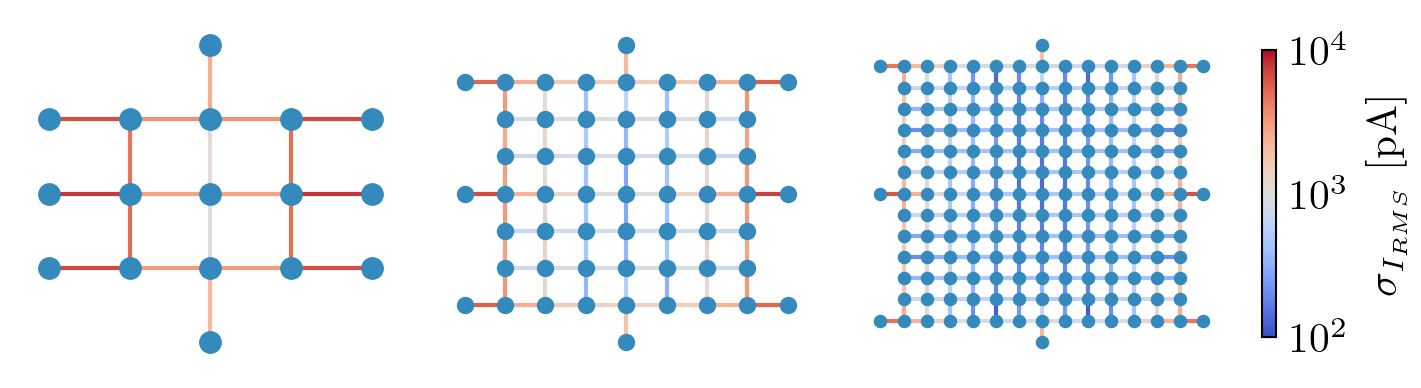

In [71]:
fig = plt.figure(dpi=300, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
fig.set_figheight(fig.get_figheight()*0.65)

w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

n_s  = [20,10,5]
axes = []
for i, N_val in enumerate([3,7,13]):
    arr_I = np.load(f"data/{N_val}_arr_I_f0_1.npy")
    ax  = fig.add_subplot(1,3,i+1)
    axes.append(ax)
    G   = create_weighted_undirected_graph(pd.Series(np.std(arr_I,axis=0)*1e-6, idx_store[N_val]))
    ax  = display_net_flow_graph(G, pos=pos_store[N_val], log_scale=True, font_size=None, ax=ax,
                                 vmin=1e2, vmax=1e4, node_size=n_s[i], cmap=plt.cm.coolwarm)
norm = colors.LogNorm(vmin=1e2, vmax=1e4)
sm = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.coolwarm)
sm.set_array([])

fig.colorbar(sm, ax=axes, location="right", pad=0.02, shrink=0.8, label='$\sigma_{I_{RMS}}~[\mathrm{pA}]$')

fig.savefig(f"plots/pdf/sens_graphs.pdf", transparent=False)
fig.savefig(f"plots/svg/sens_graphs.svg", transparent=True)
fig.savefig(f"plots/png/sens_graphs.png", transparent=False)

In [31]:
arrs = {}
for N_val in [5,7,9,11,13]:
    arr_I   = np.load(f"data/{N_val}_arr_I_f0_1.npy")
    G       = create_weighted_undirected_graph(pd.Series(np.std(arr_I,axis=0), idx_store[N_val]))
    arr1    = np.array([[G.get_edge_data(start*N_val+i+8,start*N_val+i+1+8)['weight'] for i in range(0,N_val//2)]
                        for start in range(0,N_val,N_val//2)])
    arr2    = np.array([list(reversed([G.get_edge_data(start*N_val+i+8+N_val//2,start*N_val+i+1+8+N_val//2)['weight'] for i in range(0,N_val//2)]))
                        for start in range(0,N_val,N_val//2)])
    arr     = np.vstack([arr1,arr2])
    arrs[N_val] = arr

### Get the Noise Floor

In [32]:
def func_1(x, a, b, c):
    return a*np.exp(-x/b) + c

corner_idx = [0,2,3,5]
edge_idx   = [1,4]

noise_vals = []
for j in range(6):
    arr = arrs[13][j,:].copy()
    x_v = np.arange(len(arr))
    y_v = arr.copy()

    p,cov = curve_fit(func_1, x_v, y_v, p0=[1e9,1,1e8])
    noise_vals.append(p[-1])

noise_vals          = np.array(noise_vals)
noise_floor         = np.mean(noise_vals)
noise_floor_corner  = np.mean(noise_vals[corner_idx])
noise_floor_edge    = np.mean(noise_vals[edge_idx])
noise_floors        = [noise_floor_corner,
                       noise_floor_edge,
                       noise_floor_corner,
                       noise_floor_corner,
                       noise_floor_edge,
                       noise_floor_corner]

### Fit sigma curves

In [33]:
p_vals = {}
c_vals = {}
for i, N_val in enumerate([5,7,9,11,13]):
    p_vals[N_val] = []
    c_vals[N_val] = []
    for j in range(6):
        arr = arrs[N_val][j,:].copy()
        x_v = np.arange(len(arr))
        y_v = arr.copy()
        def func_2(x, a, b):
            return a*np.exp(-x/b) + noise_floors[j]
        p,cov = curve_fit(func_2, x_v, y_v, p0=[1e9,1])
        p_vals[N_val].append(p)
        c_vals[N_val].append(cov)

xi_vals = np.array([np.array(p_vals[N])[:,-1] for N in [5,7,9,11,13]])

/tmp/ipykernel_32514/175130913.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  p,cov = curve_fit(func_2, x_v, y_v, p0=[1e9,1])


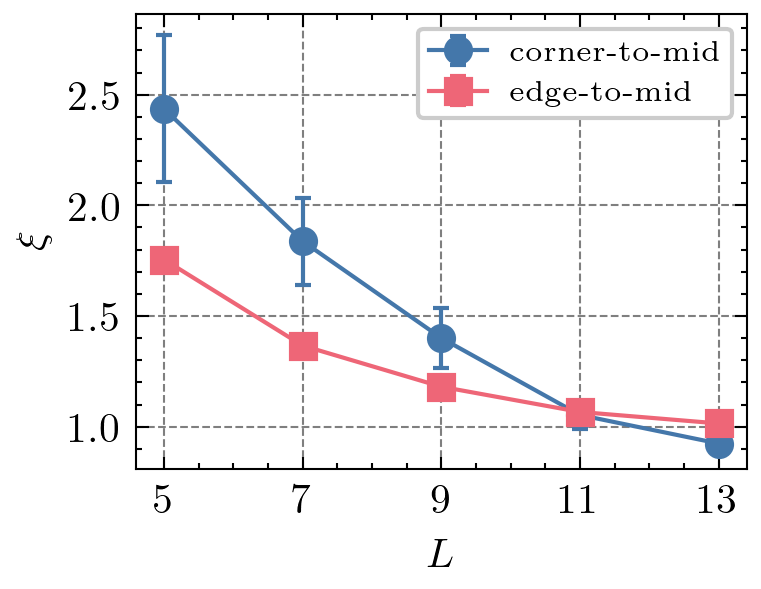

In [36]:
fig     = plt.figure(dpi=300)
ax      = fig.add_subplot()
w, h    = fig.get_size_inches()
scale   = 0.75
fig.set_size_inches(w * scale, h * scale)

_   = ax.errorbar([5,7,9,11,13], np.mean(xi_vals[:,corner_idx],axis=1), np.std(xi_vals[:,corner_idx],axis=1), marker='o', capsize=2, label='corner-to-mid')
_   = ax.errorbar([5,7,9,11,13], np.mean(xi_vals[:,edge_idx],axis=1), np.std(xi_vals[:,edge_idx],axis=1), marker='s', capsize=2, label='edge-to-mid')
_   = ax.set_xlabel("$L$")
_   = ax.set_ylabel("$\\xi$")
_   = ax.legend(fontsize='x-small')
_   = ax.set_xticks(N_PARTICLES[1:-1])

fig.savefig(f"plots/pdf/xi_vs_L.pdf", transparent=False)
fig.savefig(f"plots/svg/xi_vs_L.svg", transparent=True)
fig.savefig(f"plots/png/xi_vs_L.png", transparent=False)

TypeError: func() missing 1 required positional argument: 'c'

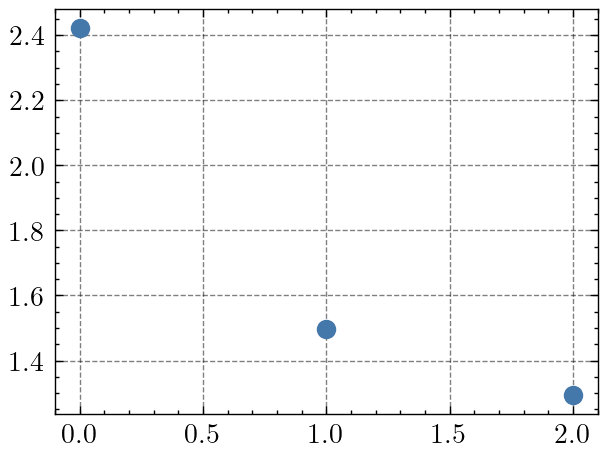

In [213]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
mss = ['o','s','^','v','<','>']
for i, N_val in enumerate([7,9,15]):
    arr = np.mean(arrs[N_val].copy(),axis=0)
    x_v = np.arange(len(arr))
    y_v = arr.copy()
    # y_v = (y_v - y_v[-1]) / y_v[0]
    pp  = ax.plot(x_v, y_v*1e-9, mss[i], label=f'$L = {N_val}$')
    _   = ax.plot(x_v, func(x_v, *np.mean(p_vals[N_val],axis=0))*1e-9, color=pp[0].get_color())
_ = ax.legend()
_ = ax.set_xlabel("$L$")
_ = ax.set_ylabel("$\sigma_I$ [nA]")
fig.savefig("sigma_vs_L.png")

In [48]:
np.array(p_vals)[:,1]

array([0.79943295, 1.08381735])

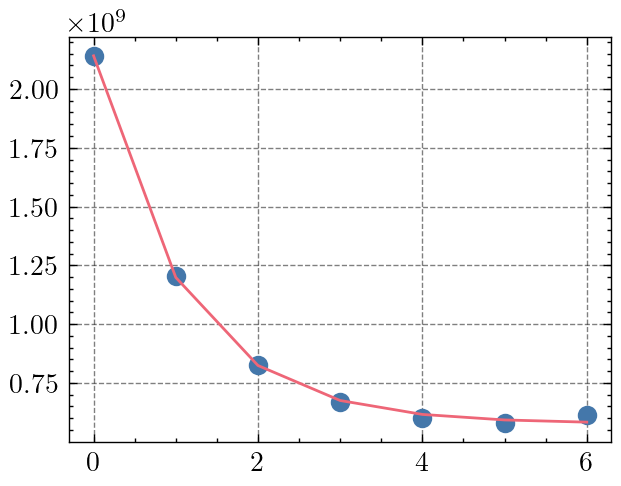

In [16]:
def func(x, a, b, c):
    return a*np.exp(-x/b) + c

x_v = np.arange(len(arr))
y_v = arr.copy()
p,_ = curve_fit(func, x_v, y_v, p0=[1e9,1,1e8])

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
_   = ax.plot(x_v, y_v, 'o')
_   = ax.plot(x_v, func(x_v, *p))

In [438]:
p

array([1.92066101e+09, 3.27448414e+00])

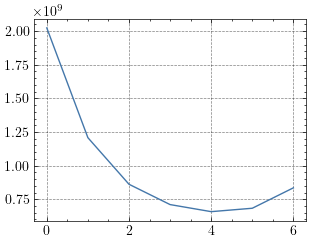

In [422]:
plt.plot(arr1[2,:])

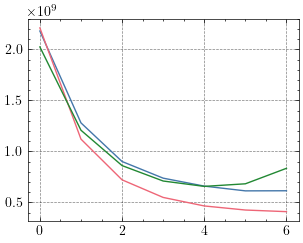

In [416]:
for i in range(3):
    plt.plot(arr[i,:])

In [396]:
[i for i in range(0,N_val,N_val//2)]

[0, 7, 14]

In [399]:
[[(start*N_val+i+8,start*N_val+i+1+8) for i in range(0,N_val//2)] for start in range(0,N_val,N_val//2)]

[[(8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (13, 14), (14, 15)],
 [(113, 114),
  (114, 115),
  (115, 116),
  (116, 117),
  (117, 118),
  (118, 119),
  (119, 120)],
 [(218, 219),
  (219, 220),
  (220, 221),
  (221, 222),
  (222, 223),
  (223, 224),
  (224, 225)]]

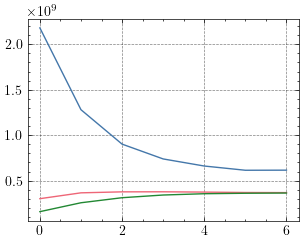

In [400]:
for i in range(3):
    plt.plot(arr[i,:])

In [350]:
G.edges

EdgeView([(0, 15), (15, 14), (15, 16), (15, 30), (1, 8), (8, 9), (8, 23), (2, 22), (22, 21), (22, 37), (3, 113), (113, 98), (113, 114), (113, 128), (4, 127), (127, 112), (127, 126), (127, 142), (5, 218), (218, 203), (218, 219), (6, 232), (232, 217), (232, 231), (7, 225), (225, 210), (225, 224), (225, 226), (9, 10), (9, 24), (23, 24), (23, 38), (10, 11), (10, 25), (24, 25), (24, 39), (11, 12), (11, 26), (25, 26), (25, 40), (12, 13), (12, 27), (26, 27), (26, 41), (13, 14), (13, 28), (27, 28), (27, 42), (14, 29), (28, 29), (28, 43), (29, 30), (29, 44), (16, 17), (16, 31), (30, 31), (30, 45), (17, 18), (17, 32), (31, 32), (31, 46), (18, 19), (18, 33), (32, 33), (32, 47), (19, 20), (19, 34), (33, 34), (33, 48), (20, 21), (20, 35), (34, 35), (34, 49), (21, 36), (35, 36), (35, 50), (36, 37), (36, 51), (37, 52), (38, 39), (38, 53), (39, 40), (39, 54), (40, 41), (40, 55), (41, 42), (41, 56), (42, 43), (42, 57), (43, 44), (43, 58), (44, 45), (44, 59), (45, 46), (45, 60), (46, 47), (46, 61), (47,

In [335]:
vals = []
for i, N_val in enumerate([3,9,15]):
    arr_I = np.load(f"data/{N_val}_arr_I.npy")
    vals.append(np.sum(np.std(arr_I,axis=0)))

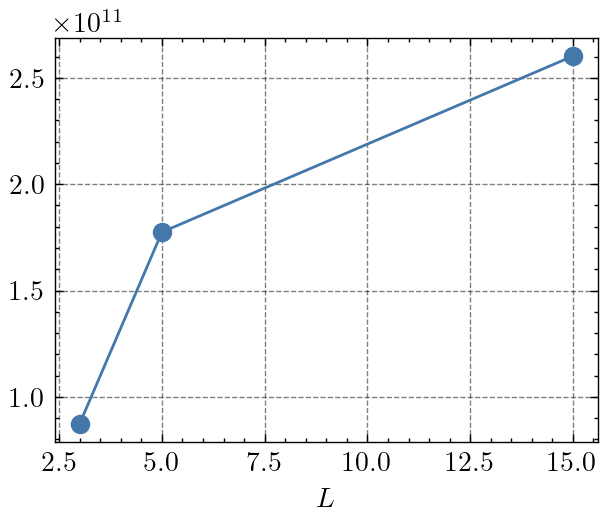

In [343]:
fig, ax = plt.subplots(dpi=200)
_       = ax.plot([3,5,15], vals,'o-')
_       = ax.set_xlabel("$L$")
_       = ax.set_ylabel("")

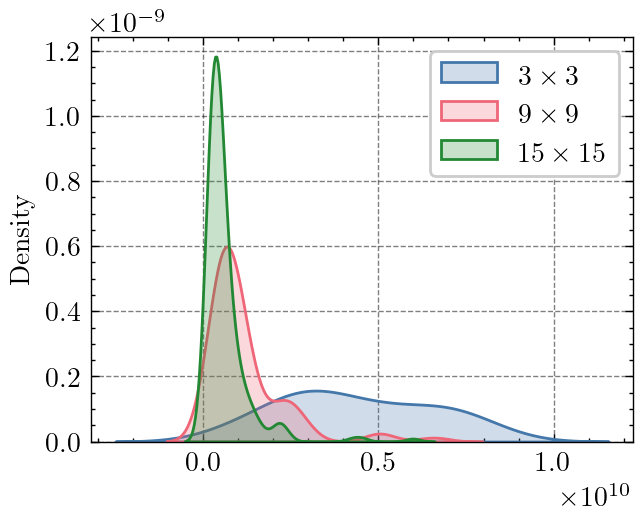

In [ ]:
fig, ax = plt.subplots(dpi=200)
for N in [3,9,15]:
    arr_I   = np.load(f"data/{N}_arr_I.npy")
    arr_C   = np.load(f"data/{N}_arr_C.npy")
    ax      = sns.kdeplot(np.std(arr_I,axis=0)/np.mean(arr_I,axis=0), ax=ax, fill=True, label=f"${N} \\times {N}$")
ax.legend()
fig.savefig("test.png")

---

In [34]:
ctrl_volt = {N : np.array([data[N][i].loc[0,"E1":"E6"].round(6).values for i in range(N_SAMPLES)])}

In [4]:
R_VALUES    = [50.0,100.0,200.0,400.0,800.0,1600.0]
N_SAMPLES_R = 608
data_R_15   = {R : {i : pd.read_csv(f"{PATH_R}Nx=9_Ny=9_Ne=8_{i}_mean2_{R}_15.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-6 for i in range(N_SAMPLES_R)} for R in R_VALUES}
data_R_10   = {R : {i : pd.read_csv(f"{PATH_R}Nx=9_Ny=9_Ne=8_{i}_mean2_{R}_10.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-6 for i in range(N_SAMPLES_R)} for R in R_VALUES}
data_R_19   = {R : {i : pd.read_csv(f"{PATH_R}Nx=9_Ny=9_Ne=8_{i}_mean2_{R}_19.csv").iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-6 for i in range(N_SAMPLES_R)} for R in R_VALUES}

In [5]:
N_SAMPLES   = 608
data_3      = {i : pd.read_csv(f"{PATH}Nx=3_Ny=3_Ne=8_{i}.csv") for i in range(N_SAMPLES)}
data_9      = {i : pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8_{i}.csv") for i in range(N_SAMPLES)}
data_new_3  = [data_3[i].iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-6 for i in range(N_SAMPLES)]
data_new_9  = [data_9[i].iloc[N_EQ_PERIODS*SAMPLE_P_PERIOD:].reset_index(drop=True)['Observable'].values*1e-6 for i in range(N_SAMPLES)]

In [6]:
dim             = 2
n_vals          = np.arange(1,dim+1,1)
hh_vector_3     = np.array([hh_amplitudes(data_new_3[i], n_vals) for i in range(N_SAMPLES)])
hh_vector_9     = np.array([hh_amplitudes(data_new_9[i], n_vals) for i in range(N_SAMPLES)])

### Convex Hull

45.90216780360559
93.94471801328905


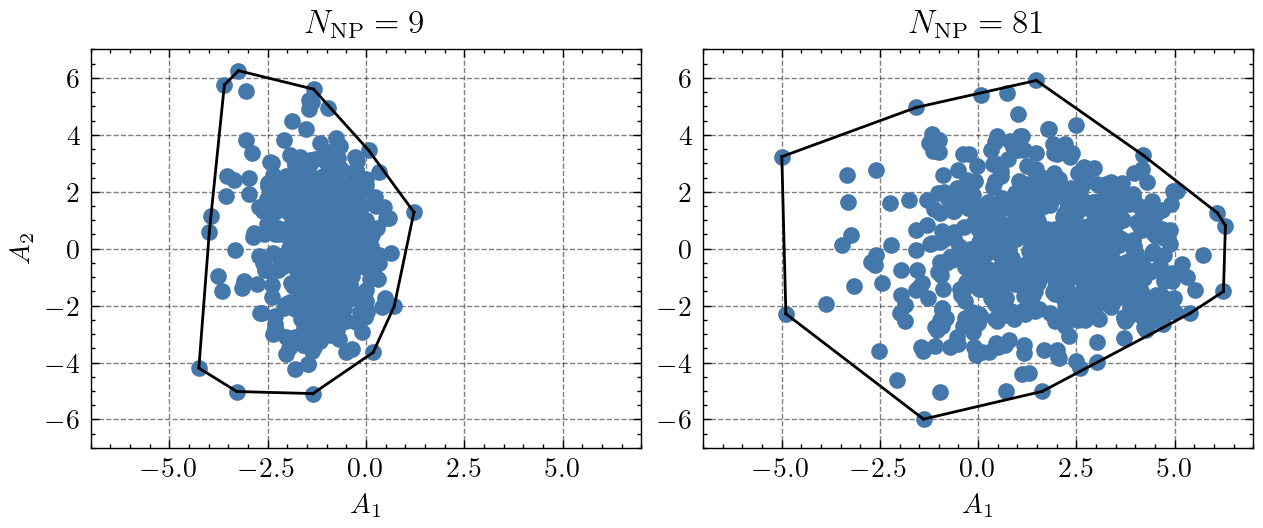

In [8]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*1.8)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

hull    = ConvexHull(hh_vector_3)
V_hull  = hull.volume
print(V_hull)
ax1.plot(hh_vector_3[:,0], hh_vector_3[:,1], 'o', ms=5)
for simplex in hull.simplices:
    ax1.plot(hh_vector_3[simplex, 0], hh_vector_3[simplex, 1], 'k-')
ax1.set_xlim(-7,7)
ax1.set_ylim(-7,7)
# ax1.set_xlim(0,50)
ax1.set_title("$N_\\textrm{NP} = 9$")
ax1.set_xlabel("$A_1$")
ax1.set_ylabel("$A_2$")

hull    = ConvexHull(hh_vector_9)
V_hull  = hull.volume
print(V_hull)
ax2.plot(hh_vector_9[:,0], hh_vector_9[:,1], 'o', ms=5)
for simplex in hull.simplices:
    ax2.plot(hh_vector_9[simplex, 0], hh_vector_9[simplex, 1], 'k-')
ax2.set_xlim(-7,7)
ax2.set_ylim(-7,7)
ax2.set_title("$N_\\textrm{NP} = 81$")
ax2.set_xlabel("$A_1$")

fig.savefig("plots/png/enclosed_area_comp.png", transparent=False)
fig.savefig("plots/pdf/enclosed_area_comp.pdf", transparent=False)
fig.savefig("plots/svg/enclosed_area_comp.svg", transparent=True)